<center><h2>Introduction to Jax</h2></center>

# 1. Installation of Jax

For CPU installation across all platforms, use

`pip install -U jax`

To utilize Nvidia GPU, AMD GPU, Google TPU, or Apple ARM GPU, you need to use other commands to install Jax. See [https://jax.readthedocs.io/en/latest/installation.html](https://jax.readthedocs.io/en/latest/installation.html) for details.  

In [42]:
import jax.numpy as jnp
import jax
import time

# 2. Basic array operation

As the name suggests, the jax.numpy package is almost the same as our familiar numpy package. 

In [43]:
x = jnp.array([1.,2.,3.])
y = jnp.ones((3))
print(f"x = {x}, y = {y},  dotproduct = {jnp.dot(x,y)}")



x = [1. 2. 3.], y = [1. 1. 1.],  dotproduct = 6.0


# 3. Just-in-time Compilation


In [44]:
def addone(x): # This function adds value 1 to all entries of the input. It is intentionally written to be slow (with a for loop)
    for i in range(x.shape[0]):
        x = x.at[i].set(x[i]+1) # This basically means x[i] = x[i] + 1. One notable difference between jax and numpy is jax arrays are immutable
    print("Add one finished")
    return x

# Let's see how long it takes to run this function
x = jnp.ones((10000))
start_time = time.time()
x_addone = addone(x)
end_time = time.time()

print(f"The time it takes to perform addone is {end_time-start_time} seconds")

Add one finished
The time it takes to perform addone is 2.0907797813415527 seconds


Let jit the addone function and run the new function. 

In [45]:
# Let's JIT this funciton to get addone_jix
addone_jit = jax.jit(addone)

# Let's see how long it takes to run this function
start_time = time.time()
x_addone_jit = addone_jit(x)
end_time = time.time()

print(f"The time it takes to perform addone_jix for the first time is {end_time-start_time} seconds")

Add one finished
The time it takes to perform addone_jix for the first time is 44.31190013885498 seconds


When you run the addone_jit function for the first time, it is quite slow as jax is tracing the computation in addone, and produce and optimize the computation graph. After running addone_jit for the first time, running it again will be very fast.

In [46]:
# running addone_jix for a second time
start_time = time.time()
x_addone_jit = addone_jit(x)
end_time = time.time()
print(f"The time it takes to perform addone_jix for the second time is {end_time-start_time} seconds")


The time it takes to perform addone_jix for the second time is 0.0009500980377197266 seconds


Also, you will find that the print out of "Add one finished" is gone. This is because after jit, the code on "print" is ignored as it is unrelated to the computation. 

# 4. Gradient Computation

Gradient computation in Jax has a more "mathematical" feel compared to pytorch. In mathematics, a gradient is defined for a function. For example, given a funciton f(x) = x^2, the gradient function is f'(x) = 2*x. This is exactly what jax.grad does: it takes a function as input, and outputs the gradient function. Usage-wise, this is quite different from the "backward" in pytorch and is more tailored to scientific computing. 

In [47]:

def square(x): # a simple square function 
    return x*x

grad_square = jax.grad(square) # grad_square will be the gradient function of f(x) = x^2, which is 2*x

x = jnp.array(3.)
grad_square(3.) # The expected result is 2*x


Array(6., dtype=float32, weak_type=True)

In the above example, you can apply jax.grad to grad_square, which will return the second-order derivative of the function square. You can keep doing this and get the derivative of arbitrary order. Taking higher-order derivative is something that is awkward to do in PyTorch. This again speaks to the focus of jax on scientific computing.   

In [48]:
second_order_grad_square = jax.grad(grad_square)

second_order_grad_square(x) # this should just return value 2 regardless of x

Array(2., dtype=float32, weak_type=True)

# 5. Train a Neural Network with Jax

In this section, we will use Jax to build and train a simple neural network. As Jax is targeted towards scientific computing, it doesn't have built-in support for building neural networks (like the nn.linear in PyTorch). Therefore, we need to build a Neural network from scratch. 

In [51]:
# define the ReLU activation function
def relu(x):
  return jnp.maximum(0, x)

# This function defines our neural network, and acts similarly as the forward funciton in PyTorch
def mymodel(params, input): 
  intermediate_layers = input
  for w, b in params[:-1]: # go through the weights (w,b) in all layers
    intermediate_layers = relu(jnp.dot(w, intermediate_layers) + b)

  final_w, final_b = params[-1]
  output = jnp.dot(final_w, intermediate_layers) + final_b
  return output

# A helper function to randomly initialize weights and biases for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = jax.random.split(key)
  return scale * jax.random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = jax.random.split(key, len(sizes))
  # Return tuple (w,b) for all layers stored as a list
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# input and output dimension is 1, and two hidden layers both have dimension 64. 
layer_sizes = [1, 64, 64, 1] 

# Initialize weight for the neural network with size as "layer_sizes"
params = init_network_params(layer_sizes, jax.random.key(0))



Let's now try to use mymodel to predict on some inputs. 

In [59]:
x = jnp.array([1.0])
print(mymodel(params,x))

x = jnp.array([[1.0],[2.0]])
print(mymodel(params,x))


[-0.00505284]


TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (2,).

In the above example, when using mymodel to make prediction on a single input, it will function properly. However, when making prediciton on a batch of two values, it throws an error on the dimension mismatch. While we could rewrite mymodel such that it supports taking batches of input, Jax provides jax.vmap which automatically vectorizes a function such that it can take a batch (vector) of inputs. 



In [61]:
# jax.vmap transforms a function to a vectorized function that take a batch of inputs
# in_axes means which axis is the axis for "batch". 
# The first "None" is because the first input of mymodel is params, which we are not vectorizing
# The second "0" means for the second input of mymodel, the first axis is the axis for batch
mymodel_batch = jax.vmap(mymodel, in_axes=(None, 0))

x = jnp.array([[1.0],[2.0]]) # x is of shape (2,1), and the first axis "2" indicates this is a batch of 2 inputs
print(mymodel_batch(params,x))


[[-0.00505284]
 [-0.00506019]]


Let's now use Jax to conduct a simple regression problem. 

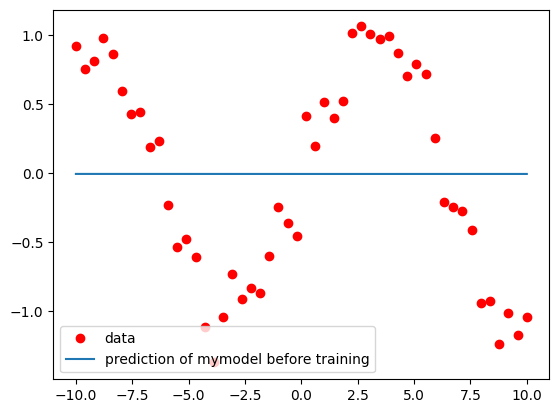

In [64]:
import matplotlib.pyplot as plt

# preparing data
N_samples = 50
x = jnp.linspace(-10,10,N_samples)
x = x[:,None]
y = jnp.sin(0.5*x) + jax.random.normal(jax.random.key(0),(N_samples,1))*0.2


prediction = mymodel_batch(params,x)#
plt.plot(x,y,'ro')
plt.plot(x,prediction)
plt.legend(['data','prediction of mymodel before training'])


In [68]:
# define loss function
def mse_loss(param,x,y):
    return jnp.average((mymodel_batch(param,x) - y)**2)

# gradient of loss w.r.t. the model parameters. 
# argnums=0 means we are taking gradient only w.r.t. the first argument of mse_loss, which is param.
grad_func = jax.grad(mse_loss,argnums=0)

# The below function performs a single gradient step. Note that we jit this function by the decorator @jax.jit
@jax.jit
def gradient_descent_step(params,x,y,learning_rate):
    grad = grad_func(params,x,y)
    return [(w - learning_rate * dw, b - learning_rate * db)
          for (w, b), (dw, db) in zip(params, grad)]

In [69]:
# setting learning rate and number of epochs
lr = 0.1
num_epochs = 1000

loss_list = []


for _ in range(num_epochs):
    params = gradient_descent_step(params,x,y,lr) # gradient step
    loss = mse_loss(params,x,y)
    loss_list.append(loss)

    


conducting gradient step
Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)> [(Traced<ShapedArray(float32[64,1])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/0)>), (Traced<ShapedArray(float32[64,64])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/0)>), (Traced<ShapedArray(float32[1,64])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>)]


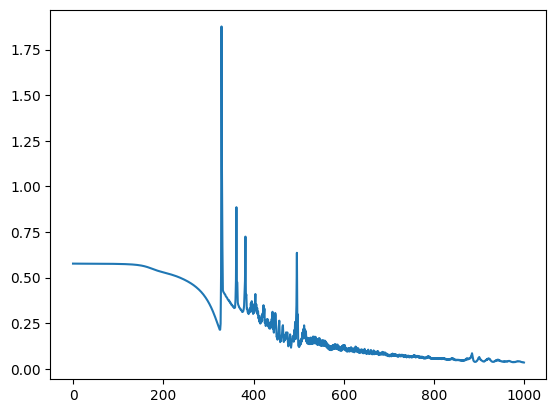

In [41]:
plt.plot(range(num_epochs),loss_list)

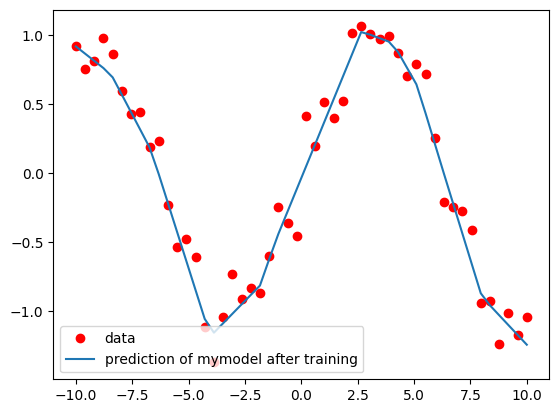

: 

In [70]:
prediction = mymodel_batch(params,x)
plt.plot(x,y,'ro')
plt.plot(x,prediction)
plt.legend(['data','prediction of mymodel after training'])
